# Alpha analysis

April 2017 Alpha analysis

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
import invisible_cities.core.system_of_units_c as SystemOfUnits
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2

pi = np.pi

import scipy.optimize as optm

Running on  Tue Apr 25 19:48:50 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-25 19:48:52


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

/Users/jjgomezcadenas/miniconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


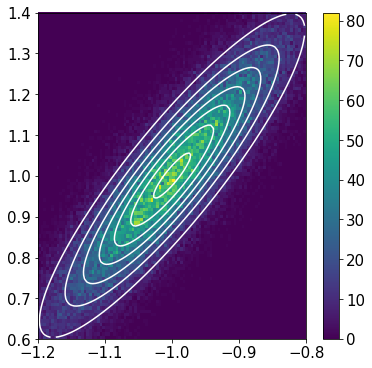

In [5]:

def gauss2d(xy, A, x0, y0, sx, sy, rho, ravel=True):
    rho2 = 1 - rho**2
    dx   = (xy[0] - x0) / sx
    dy   = (xy[1] - y0) / sy
    g    = A/(2*np.pi*sx*sy*rho2**0.5)
    g   *= np.exp( (-dx**2 - dy**2 + 2*rho*dx*dy)/(2*rho2) )
    return g.ravel() if ravel else g


def random(mus, sigmas, rho, N=100000):
    cov      = np.diag(sigmas)**2
    cov[0,1] = \
    cov[1,0] = rho * sigmas[0] * sigmas[1]
    return np.random.multivariate_normal(mus, cov, N).T


def plot_data(x, y, nx=100, ny=100, nsigma=2):
    mux , muy  = np.mean(x), np.mean(y)
    rmsx, rmsy = np.std (x), np.std (y)
    xrange     = mux - nsigma*rmsx, mux + nsigma*rmsx
    yrange     = muy - nsigma*rmsy, muy + nsigma*rmsy
    z, x, y, _ = \
    plt.hist2d(x, y, (nx, ny), (xrange, yrange))
    plt.colorbar()

    x = x[:-1] + np.diff(x) * 0.5
    y = y[:-1] + np.diff(y) * 0.5
    x, y = np.meshgrid(x, y)
    return x, y, z.ravel()


def plot_fit(x, y, values):
    g = lambda x,y: gauss2d((x,y), *values, False)
    plt.contour(x, y, g(x,y), 8, colors="w", linewidth=3)


def fit(x, y, z):
    seed = np.max(z), np.mean(x), np.std(x), np.mean(y), np.std(y), 0.5
    return optm.curve_fit(gauss2d, (x,y), z, seed)

a, b      = random([-1, +1], [0.1, 0.2], 0.9)
x, y, z   = plot_data(a, b)
vals, cov = fit(x, y, z)
plot_fit(x, y, vals)

### Run Parameters

In [6]:
run_number = 3628

In [7]:
KDST = {3628:'LSC/kdst/3628/kdst_3628_full.h5', 3645:'LSC/kdst/3645/kdst_3645_1.h5'}

In [8]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [9]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_4.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'],KDST[run_number])
print("ifile:", ifile)

ifile: /Users/jjgomezcadenas/Projects/ICDATA/LSC/kdst/3628/kdst_3628_full.h5


In [10]:
full = load_dst(ifile)
print(len(full))
full.head()

557754


event          time  peak  nS2    S1w         S1h          S1e       S1t  \
0      1  1.492019e+09     0    1  325.0  343.339508  1969.230554  391325.0   
1      2  1.492019e+09     0    1  350.0  251.357895  1460.681752  552300.0   
2      3  1.492019e+09     0    1  300.0  248.654160  1424.480923  611050.0   
3      4  1.492019e+09     0    1  300.0  306.161346  1722.519528  474000.0   
4      5  1.492019e+09     0    1  350.0  325.086487  1965.504873  321875.0   

         S2w           S2h    ...          S2t  Nsipm        DT         Z  \
0  10.200625   3764.766357    ...     655137.5     13  263.8125  263.8125   
1   8.812500   9603.205078    ...     654512.5     18  102.2125  102.2125   
2   6.043062  17420.824219    ...     653562.5     18   42.5125   42.5125   
3   9.955813   7857.233887    ...     655162.5     16  181.1625  181.1625   
4  10.871688   4010.353027    ...     655487.5     11  333.6125  333.6125   

            X           Y           R       Phi      Xrms      Yrms  
0 -187.462929   30.724923  189.964130  2.979138  8.080248  8.996847  
1   85.196690  -55.503263  101.681306 -0.577409  8.714130  8.527614  
2  -85.594098   39.492259   94.265520  2.709307  8.428040  8.456854  
3 -142.918068    8.641987  143.179112  3.081198  9.182113  8.241882  
4    2.453711 -124.440975  124.465164 -1.551081  8.089127  7.935277  

[5 rows x 22 columns]

In [11]:
len(full)

557754

In [12]:
r = event_rate(full)

In [13]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 3.8194173264728035 evts/s


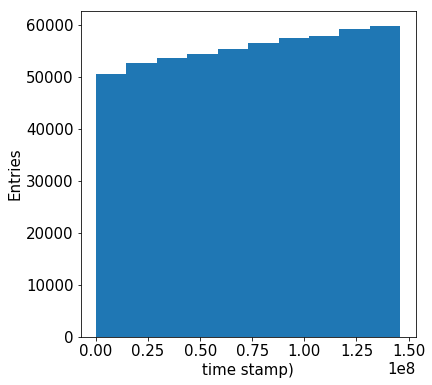

In [14]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp)", "Entries")

In [15]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

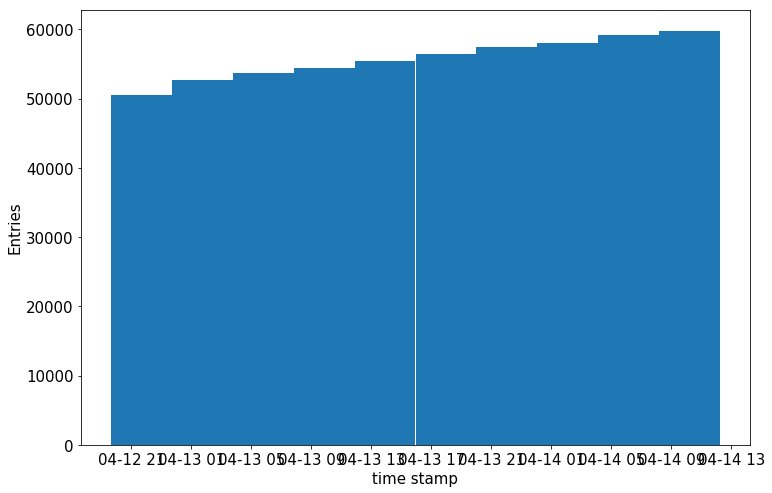

In [16]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [17]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [18]:
print(st)

2017-04-14 12:13:42


In [19]:
print(full.time.index[-1])

557753


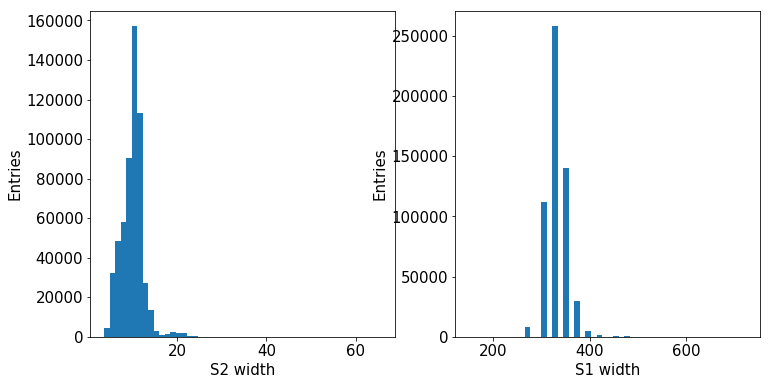

In [20]:
figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)
plt.hist(full.S2w, 50)
labels("S2 width", "Entries")

ax = plt.subplot(1, 2, 2)
plt.hist(full.S1w, 50)
labels("S1 width", "Entries")



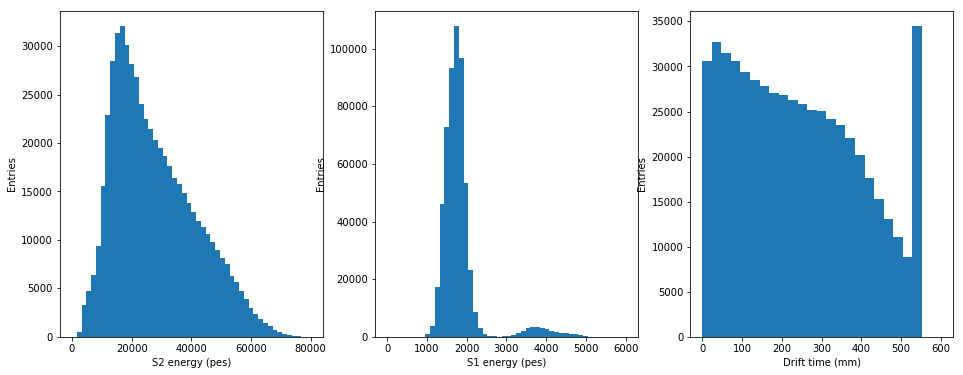

In [30]:
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,8e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,6e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")


### Cathode alphas

In [384]:
cde = full[full.Z > 540]
print("Ratio wrt full:", len(cde)/len(full))

Ratio wrt full: 0.05224262678774376


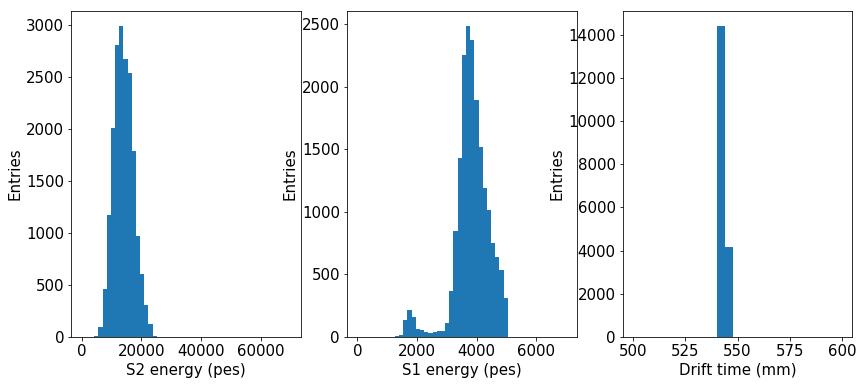

In [385]:
figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(cde.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(cde.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(cde.Z, 25, (500,600))
labels("Drift time (mm)", "Entries")

### Bulk alphas

In [342]:
blk = full[full.Z < 540]
print("Ratio wrt full:", len(blk)/len(full))

Ratio wrt full: 0.9477573732122563


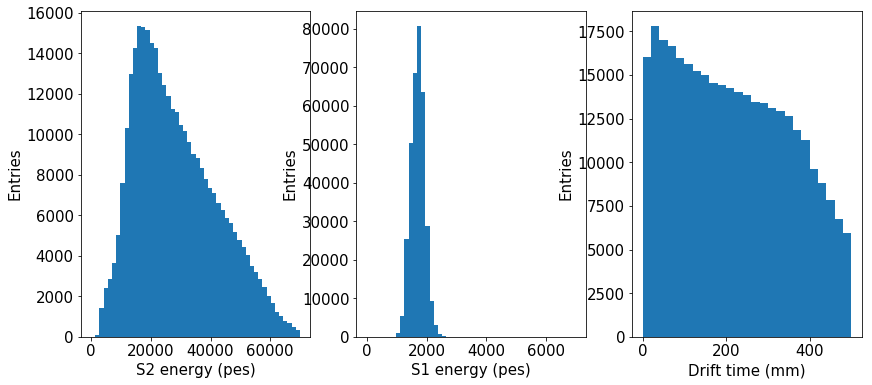

In [343]:
figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(blk.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(blk.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(blk.Z, 25, (0,500))
labels("Drift time (mm)", "Entries")

### Dependence with Z all alphas

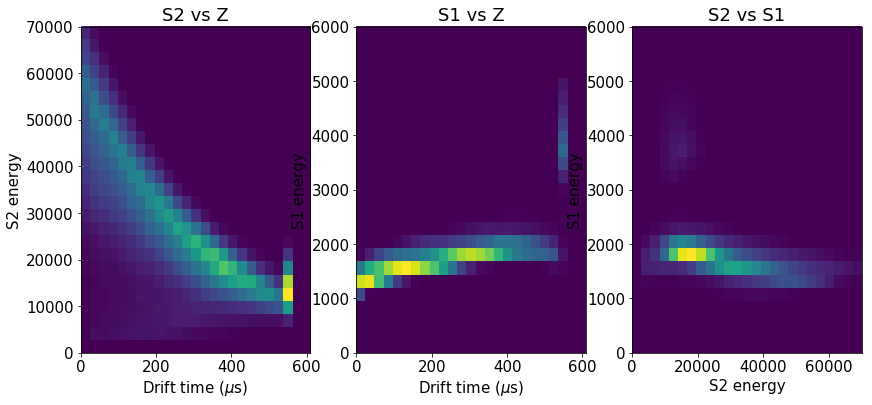

In [344]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 6e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Dependence with Z bulk alphas

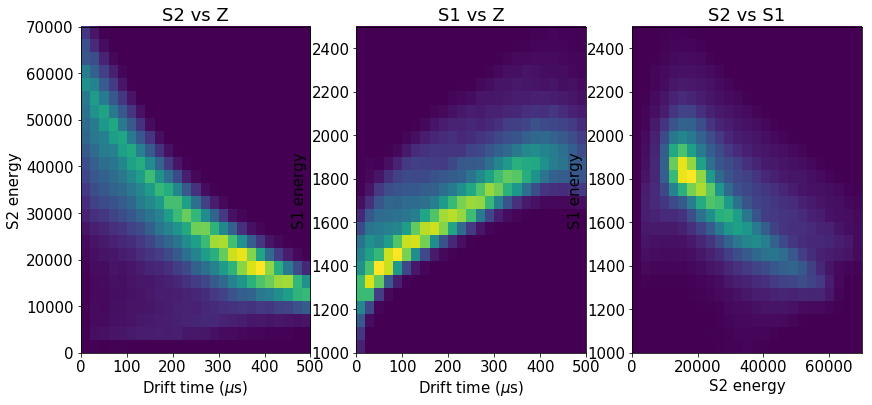

In [345]:
zrange =   0, 500
S2range = 0, 7e4
S1range = 1000, 2500

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(blk.Z, blk.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(blk.Z, blk.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(blk.S2e, blk.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')


### Fiducial volume

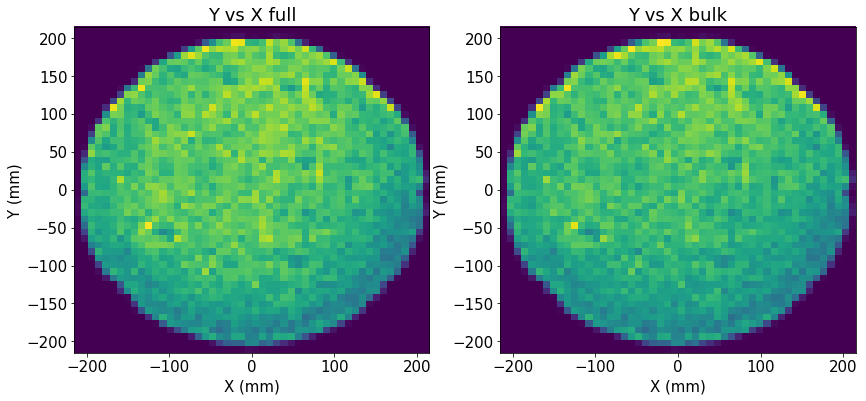

In [346]:
xrange = -215, 215
yrange = -215, 215

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X full')

ax = plt.subplot(1, 2, 2)
plt.hist2d(blk.X, blk.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X bulk')



In [347]:
fid = blk[blk.R < 180]
print("Ratio wrt full:", len(fid)/len(full))

Ratio wrt full: 0.7458365684321867


In [348]:
core = blk[blk.R < 100]
print("Ratio wrt full:", len(core)/len(full))

Ratio wrt full: 0.23839584106943928


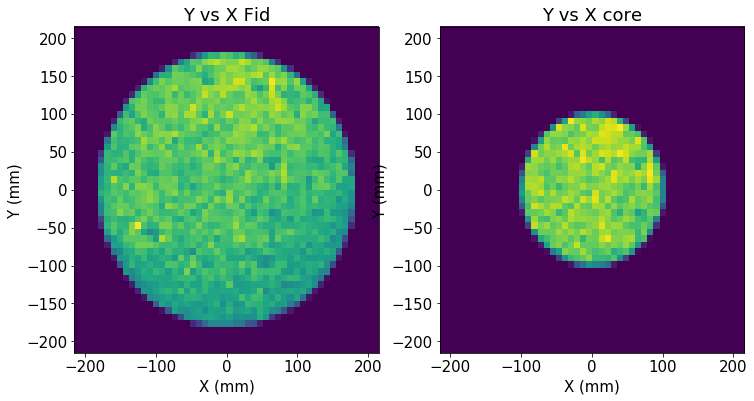

In [349]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(fid.X, fid.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

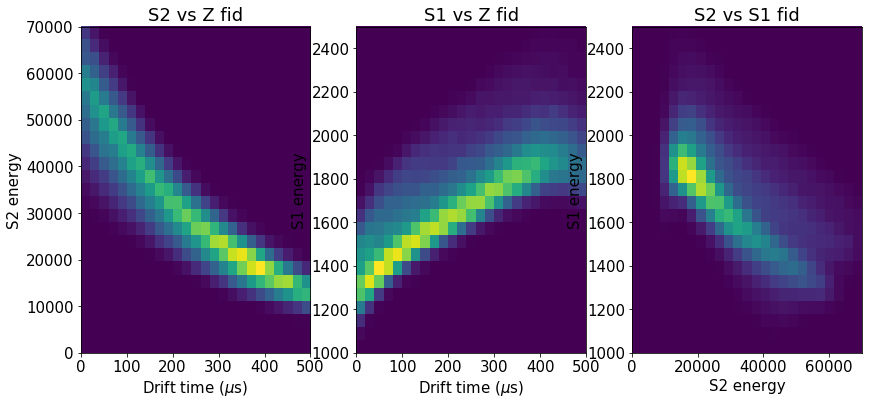

In [350]:
zrange =   0, 500
S2range = 0, 7e4
S1range = 1000, 2500

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z fid')

ax = plt.subplot(1, 3, 2)
plt.hist2d(fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z fid')

ax = plt.subplot(1, 3, 3)
plt.hist2d(fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1 fid')

### Z correction for bulk 

#### S2

fit par[0] = 63223.52225957707 error = 83.89669260599855
fit par[1] = -334.69180031341386 error = 0.6028975271174024
degrees of freedom = 2
chi2 = 1.6654658045901516


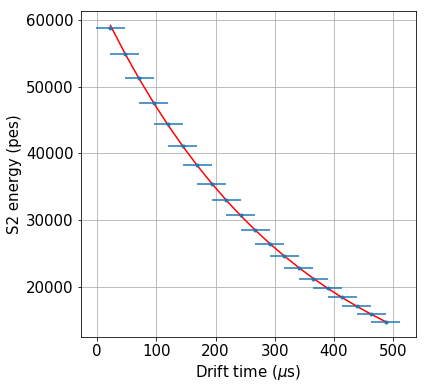

In [351]:
zrange =   10, 500
Erange = 1e+3, 70e3
nbins = 20
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### S1

fit par[0] = 1445.7808538894285 error = 15.900342540157238
fit par[1] = 1.0911564520990802 error = 0.058038975147934276
degrees of freedom = 2
chi2 = 15.642552328594839


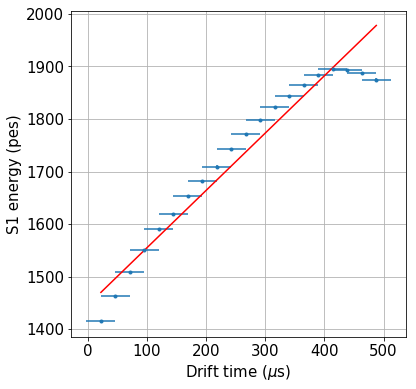

In [352]:
zrange =   10, 500
Erange = 1e+3, 2.5e3
nbins = 20
F, x, y, sy = profile_and_fit_radial(core.Z, core.S1e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(1000,2), label=("Drift time ($\mu$s)", "S1 energy (pes)"))
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [391]:
fidz = fid[in_range(fid.Z ,100, 400)]
print("Ratio wrt full:", len(fidz)/len(full))
cz = core[in_range(core.Z ,100, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.448803857363085
Ratio wrt full: 0.1439084495155791


#### Fit S2 in fiducial 

fit par[0] = 63556.88070138601 error = 89.7074659156316
fit par[1] = -332.23561785610264 error = 0.6196116530262843
degrees of freedom = 2
chi2 = 0.9456293254922178


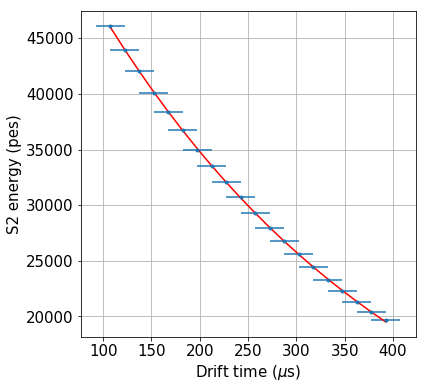

In [392]:
zrange =   100, 400
Erange = 1e+3, 70e3
nbins = 20
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [394]:
zfun  = F.fn
zmin  = np.min(z)
zcs2 = lambda z: zfun(zmin)/zfun(z)
print(zmin)

107.5


In [397]:
zc = lambda z: zfun(zmin)/zfun(550)

In [398]:
zc(550)

3.7881815276596789

#### Z corrections for S2

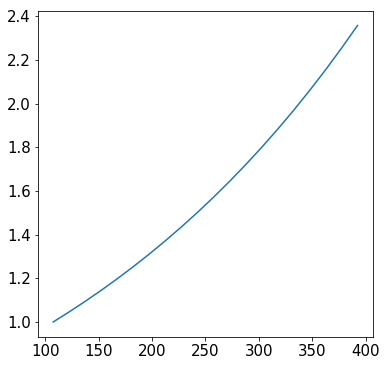

In [356]:
plt.plot(z, zcs2(z))

#### Fit S1 in fiducial 

fit par[0] = 1402.7619639749716 error = 5.1899053094332865
fit par[1] = 1.6635404636353728 error = 0.04521226254414471
fit par[2] = -0.0010927886260242614 error = 8.991323098997708e-05
degrees of freedom = 3
chi2 = 0.8867082681911682


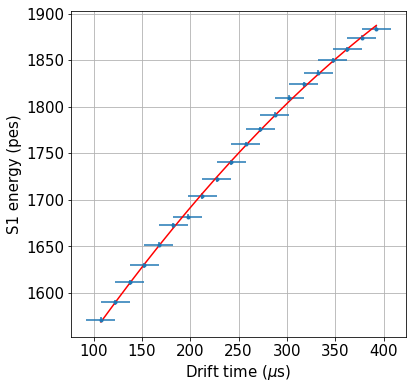

In [357]:
zrange =   100, 400
Erange = 1e+3, 2.5e3
nbins = 20
F, x, y, sy = profile_and_fit_radial(cz.Z, cz.S1e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(1000,2,0.01), label=("Drift time ($\mu$s)", "S1 energy (pes)"))
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [358]:
zfun  = F.fn
zmin  = np.min(x)
zcs1 = lambda z: zfun(zmin)/zfun(z)
print(zmin)

107.5


#### Z corrections for S1

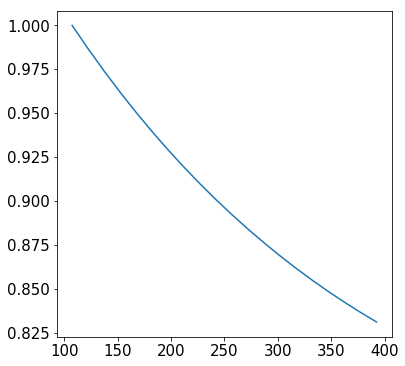

In [359]:
plt.plot(z, zcs1(z))

### Z corrected distributions

In [399]:
S2range = 1e+3, 70e3
crange = 0e+3, 50e3
S1range = 1e+3, 2500
cz =  cde.S2e * zc(550)
S2z = fidz.S2e * zcs2(fidz.Z)
S1z = fidz.S1e * zcs1(fidz.Z)

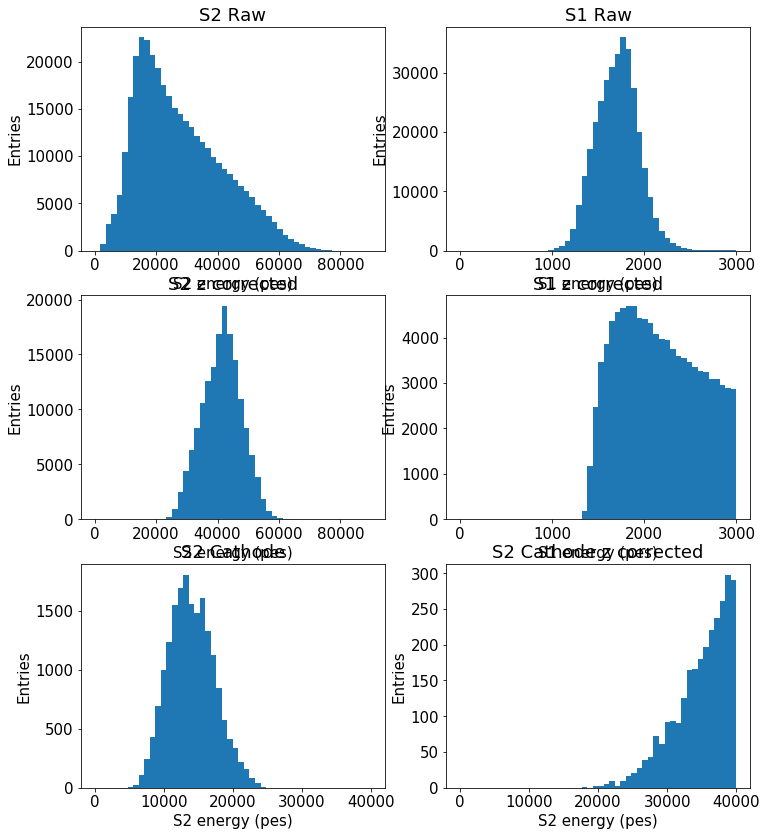

In [400]:
figsize=(12,14)
plt.figure(figsize=figsize)

ax = plt.subplot(3, 2, 1)
plt.hist(full.S2e, 50, (0e3,9e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 Raw')

ax = plt.subplot(3, 2, 2)
plt.hist(full.S1e, 50, (0e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 Raw')

ax = plt.subplot(3, 2, 3)
plt.hist(S2z, 50, (0e3,9e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 z corrected')

ax = plt.subplot(3, 2, 4)
plt.hist(S1z, 50, (0e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 z corrected')

ax = plt.subplot(3, 2, 5)
plt.hist(cde.S2e, 50, (0e3,40e3))
labels("S2 energy (pes)", "Entries")
plt.title('S2 Cathode')

ax = plt.subplot(3, 2, 6)
plt.hist(cz, 50, (0e3,40e3))
labels("S2 energy (pes)", "Entries")
plt.title('S2 Cathode z corrected')


### Radial dependence

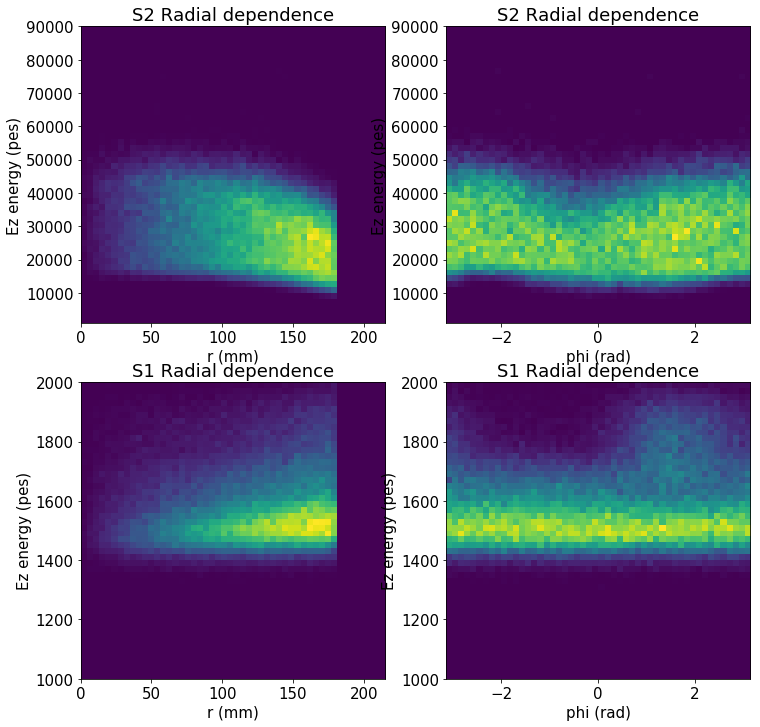

In [285]:
rrange =   0, 215
prange =   -pi, pi
S2range = 1e+3, 90e3
S1range = 1e+3, 2000
nbins = 50
figsize=(12,12)
plt.figure(figsize=figsize)

ax = plt.subplot(2, 2, 1)
plt.hist2d(fidz.R, S2z, (nbins, nbins), range=(rrange, S2range), weights=S2z)
labels("r (mm)", "Ez energy (pes)")
plt.title('S2 Radial dependence')

ax = plt.subplot(2, 2, 2)
plt.hist2d(fidz.Phi, S2z, (nbins, nbins), range=(prange, S2range), weights=S2z)
labels("phi (rad)", "Ez energy (pes)")
plt.title('S2 Radial dependence')

ax = plt.subplot(2, 2, 3)
plt.hist2d(fidz.R, S1z, (nbins, nbins), range=(rrange, S1range), weights=S1z)
labels("r (mm)", "Ez energy (pes)")
plt.title('S1 Radial dependence')

ax = plt.subplot(2, 2, 4)
plt.hist2d(fidz.Phi, S1z, (nbins, nbins), range=(prange, S1range), weights=S1z)
labels("phi (rad)", "Ez energy (pes)")
plt.title('S1 Radial dependence')

#x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
#plt.plot(x, y, profOpt)


In [298]:
xrange = -180, 180
yrange = -180, 180
Erange = 1e+3, 60e3
nbins = (50,50)
x, y, E, Ee = fitf.profileXY(fidz.X, fidz.Y, S2z, *nbins, xrange=xrange, yrange=yrange)


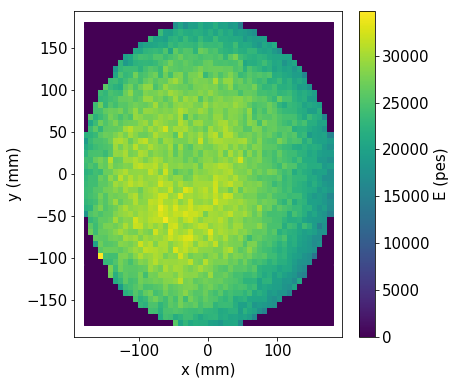

In [299]:
plot_options()
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
E_ = E.flatten()
plt.scatter(x_, y_, c=E_, marker="s")
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")


In [300]:
mxyS2 = MapXY(x, y, E)

reference energy = 29405.0467206312


In [301]:
Erange = 1e+3, 2e+3
nbins = (50,50)
x, y, E, Ee = fitf.profileXY(fidz.X, fidz.Y, S1z, *nbins, xrange=xrange, yrange=yrange)


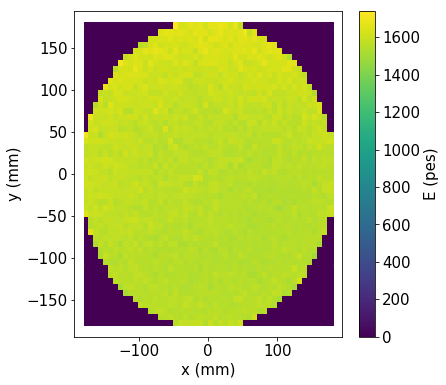

In [302]:
plot_options()
x_ = np.repeat(x, x.size)
y_ = np.tile  (y, y.size)
E_ = E.flatten()
plt.scatter(x_, y_, c=E_, marker="s")
cb = plt.colorbar()
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")

In [303]:
mxyS1 = MapXY(x, y, E)

reference energy = 1582.836558721922


### Full correction

In [306]:
S2c  = fidz.S2e.values * zcs2(fidz.Z.values) * mxyS2.xycorr(fidz.X.values, fidz.Y.values)
S1c  = fidz.S1e.values * zcs1(fidz.Z.values) * mxyS1.xycorr(fidz.X.values, fidz.Y.values)

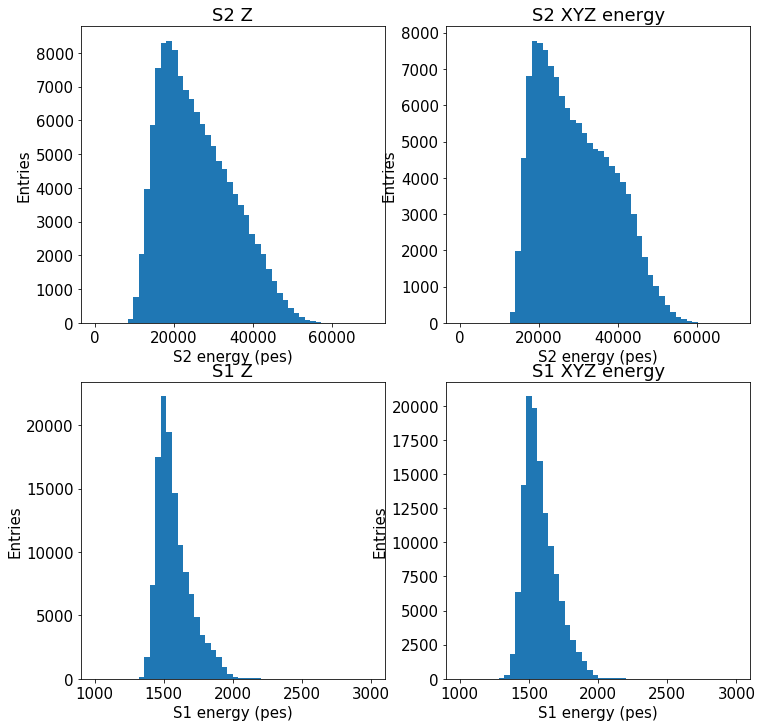

In [307]:
figsize=(12,12)
plt.figure(figsize=figsize)

ax = plt.subplot(2, 2, 1)
plt.hist(S2z, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 Z')

ax = plt.subplot(2, 2, 2)
plt.hist(S2c, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 XYZ energy')

ax = plt.subplot(2, 2, 3)
plt.hist(S1z, 50, (1e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 Z')

ax = plt.subplot(2, 2, 4)
plt.hist(S1c, 50, (1e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 XYZ energy')
          



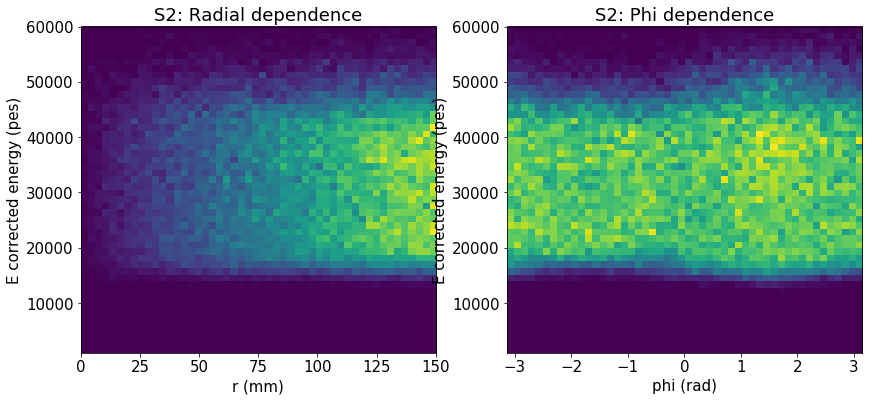

In [308]:
rrange =   0, 150
prange =   -pi, pi
Erange = 1e+3, 60e3
nbins = 50
figsize=(14,6)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 2, 1)
plt.hist2d(fidz.R, S2c, (nbins, nbins), range=(rrange, Erange), weights=S2c)
labels("r (mm)", "E corrected energy (pes)")
plt.title('S2: Radial dependence')

ax = plt.subplot(1, 2, 2)
plt.hist2d(fidz.Phi, S2c, (nbins, nbins), range=(prange, Erange), weights=S2c)
labels("phi (rad)", "E corrected energy (pes)")
plt.title('S2: Phi dependence')

#### In core volume

In [309]:
S2cc  = cz.S2e.values * zcs2(cz.Z.values) * mxyS2.xycorr(cz.X.values, cz.Y.values)
S1cc  = cz.S1e.values * zcs1(cz.Z.values) * mxyS1.xycorr(cz.X.values, cz.Y.values)

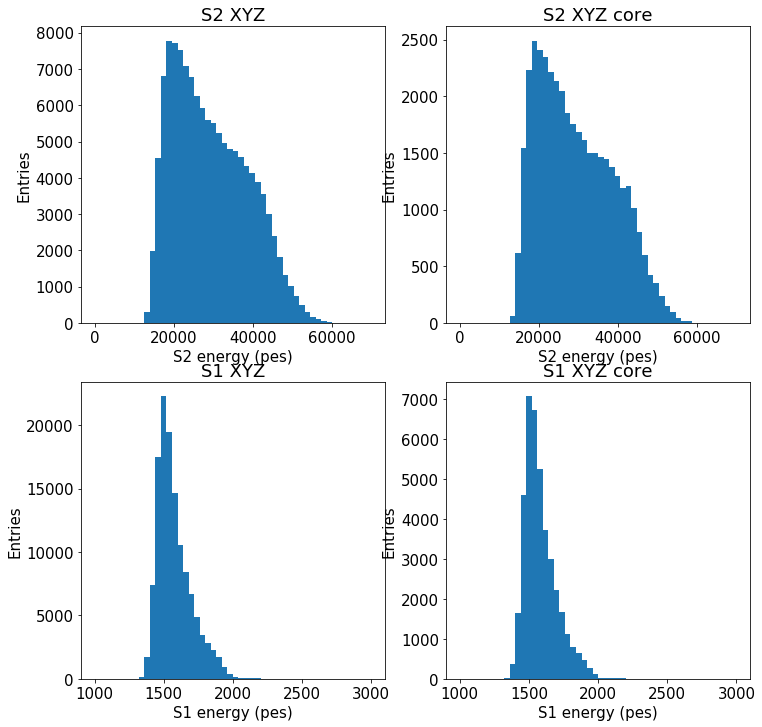

In [310]:
figsize=(12,12)
plt.figure(figsize=figsize)

ax = plt.subplot(2, 2, 1)
plt.hist(S2c, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 XYZ')

ax = plt.subplot(2, 2, 2)
plt.hist(S2cc, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 XYZ core')

ax = plt.subplot(2, 2, 3)
plt.hist(S1z, 50, (1e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 XYZ')

ax = plt.subplot(2, 2, 4)
plt.hist(S1cc, 50, (1e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 XYZ core')

### Correlation S1 -- S2

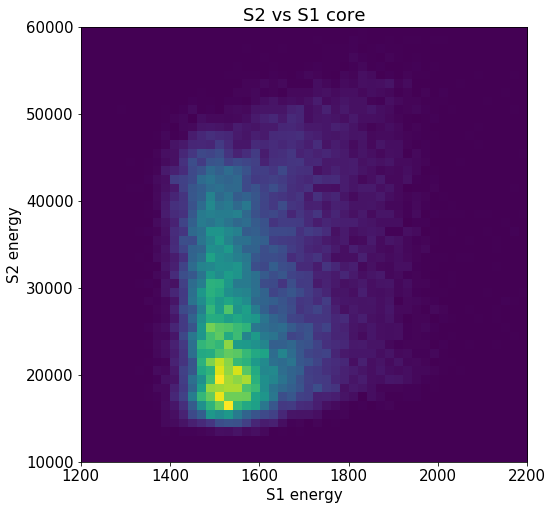

In [313]:

S2range = 1e+4, 6e4
S1range = 1200, 2200

figsize=(8,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)

plt.hist2d(S1cc, S2cc, (50, 50), range=(S1range, S2range))
labels("S1 energy", "S2 energy")
plt.title('S2 vs S1 core')

#### Need to normalize 

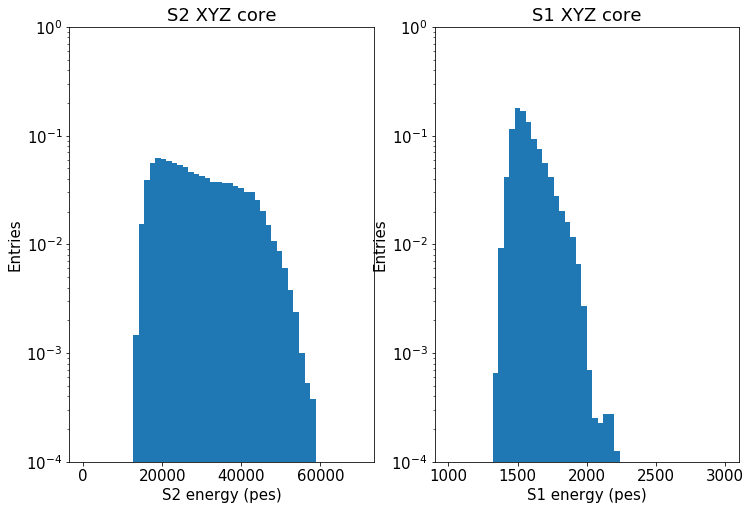

In [324]:
figsize=(12,8)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 2, 1)

pdf(S2cc, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('S2 XYZ core')

ax = plt.subplot(1, 2, 2)
pdf(S1cc, 50, (1e3,3e3))
labels("S1 energy (pes)", "Entries")
plt.title('S1 XYZ core')

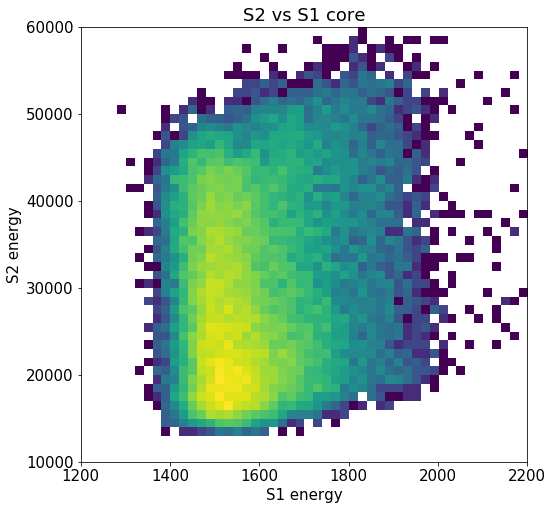

In [326]:
S2range = 1e+4, 6e4
S1range = 1200, 2200

figsize=(8,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)

plt.hist2d(S1cc, S2cc, (50, 50), range=(S1range, S2range), normed=True, norm=LogNorm())
labels("S1 energy", "S2 energy")
plt.title('S2 vs S1 core')

In [376]:
19100/500

38.2

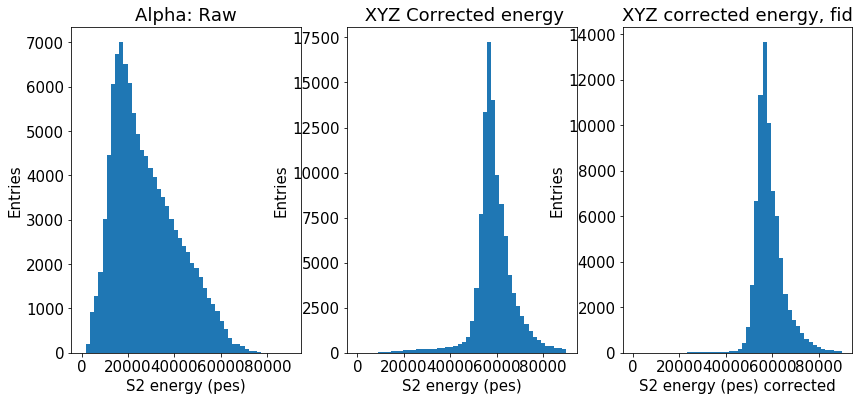

In [210]:
figsize=(14,6)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,9e4))
labels("S2 energy (pes)", "Entries")
plt.title('Alpha: Raw')

ax = plt.subplot(1, 3, 2)
plt.hist(Ec, 50, (0e3,9e4))
labels("S2 energy (pes)", "Entries")
plt.title(' XYZ Corrected energy')

ax = plt.subplot(1, 3, 3)
plt.hist(Ecf, 50, (0e3,9e4))
labels("S2 energy (pes) corrected", "Entries")
plt.title('XYZ corrected energy, fid')

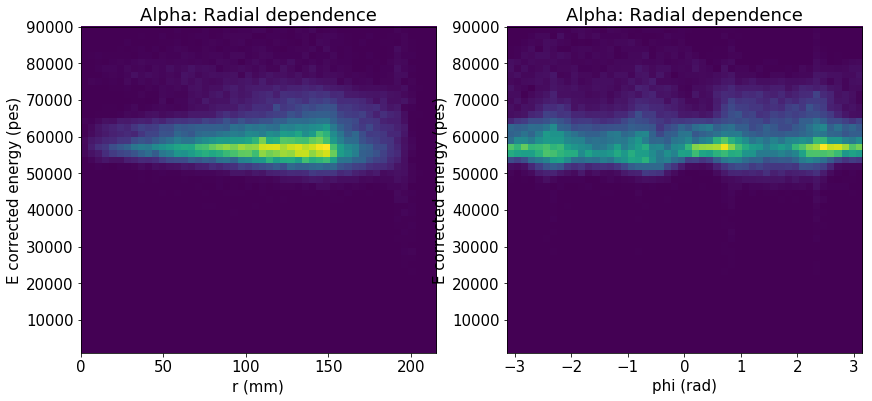

In [214]:
rrange =   0, 215
prange =   -pi, pi
Erange = 1e+3, 90e3
nbins = 50
figsize=(14,6)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 2, 1)
plt.hist2d(fidxy.R, Ecf, (nbins, nbins), range=(rrange, Erange), weights=Ecf)
labels("r (mm)", "E corrected energy (pes)")
plt.title('Alpha: Radial dependence')

ax = plt.subplot(1, 2, 2)
plt.hist2d(fidxy.Phi, Ecf, (nbins, nbins), range=(prange, Erange), weights=Ecf)
labels("phi (rad)", "E corrected energy (pes)")
plt.title('Alpha: Radial dependence')

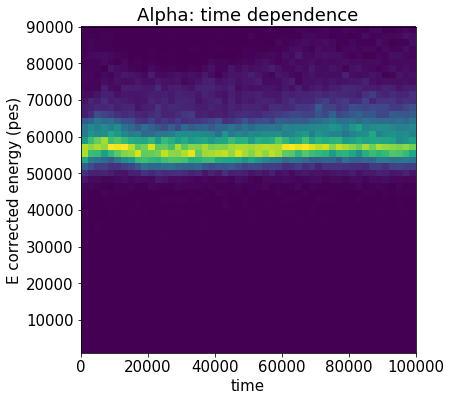

In [215]:
trange =   0, 1e+5

Erange = 1e+3, 90e3
nbins = 50
figsize=(6,6)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 1, 1)
plt.hist2d(fidxy.time.index, Ecf, (nbins, nbins), range=(trange, Erange), weights=Ecf)
labels("time", "E corrected energy (pes)")
plt.title('Alpha: time dependence')

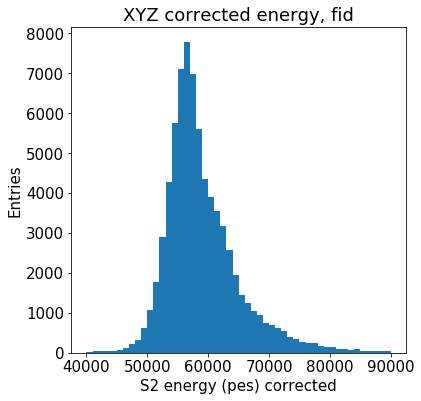

In [217]:
Erange = 40e+3, 90e3
figsize=(6,6)
plt.figure(figsize=figsize)

ax = plt.subplot(1, 1, 1)
plt.hist(Ecf, 50, Erange)
labels("S2 energy (pes) corrected", "Entries")
plt.title('XYZ corrected energy, fid')

In [ ]:
def gausstext(f):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))


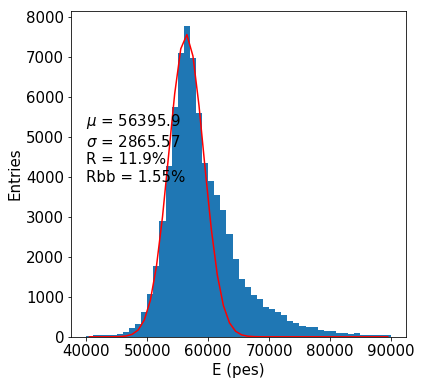

In [225]:
y, x, _ = hist(Ecf, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e6, 60e3, 5e2), fit_range=(55e+3,60e+3))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f))

labels("E (pes)", "Entries")


### DST number 2

In [226]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/kdst_3628_2.h5'.format(run_number))
print("ifile:", ifile)

ifile: /Users/jjgomezcadenas/Projects/ICDATA/LSC/kdst/3628/kdst_3628_2.h5
